In [1]:
import json
import os
import torch
import random
import xml.etree.ElementTree as ET
import torchvision.transforms.functional as FT

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

voc_labels = ('rbc', 'wbc', 'platelets')
label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
label_map['background'] = 0
rev_label_map = {v: k for k, v in label_map.items()}


distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#ffffff']
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}

In [3]:
!wget https://github.com/Shenggan/BCCD_Dataset/archive/refs/tags/v1.0.tar.gz

--2021-03-25 18:34:34--  https://github.com/Shenggan/BCCD_Dataset/archive/refs/tags/v1.0.tar.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Shenggan/BCCD_Dataset/tar.gz/refs/tags/v1.0 [following]
--2021-03-25 18:34:35--  https://codeload.github.com/Shenggan/BCCD_Dataset/tar.gz/refs/tags/v1.0
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘v1.0.tar.gz.1’

v1.0.tar.gz.1           [   <=>              ]   7.10M  11.5MB/s    in 0.6s    

2021-03-25 18:34:36 (11.5 MB/s) - ‘v1.0.tar.gz.1’ saved [7448382]



In [ ]:
!tar -zxvf  /content/v1.0.tar.gz

In [5]:
from utils import create_data_lists

create_data_lists(
    label_map,
    path='/content/BCCD_Dataset-1.0/BCCD',
    output_folder='./'
)


There are 292 training images containing a total of 876 objects. Files have been saved to /content.

There are 72 test images containing a total of 216 objects. Files have been saved to /content.


In [17]:
from train import main_train, TrainParams
from model import *

TrainParams.checkpoint = "/content/checkpoint_ssd300.pth.tar"

main_train()


Loaded checkpoint from epoch 20.



/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: [20][0/37]	Batch Time 21.134 (21.134)	Data Time 1.270 (1.270)	Loss 3.5852 (3.5852)	
Epoch: [20][3/37]	Batch Time 17.503 (18.507)	Data Time 0.002 (0.324)	Loss 3.4594 (3.4801)	
Epoch: [20][6/37]	Batch Time 17.851 (18.187)	Data Time 0.018 (0.191)	Loss 3.6236 (inf)	
Epoch: [20][9/37]	Batch Time 17.778 (18.062)	Data Time 0.014 (0.138)	Loss 3.5424 (inf)	
Epoch: [20][12/37]	Batch Time 17.841 (17.997)	Data Time 0.014 (0.110)	Loss 3.8924 (inf)	
Epoch: [20][15/37]	Batch Time 17.689 (17.960)	Data Time 0.014 (0.092)	Loss 3.5913 (inf)	
Epoch: [20][18/37]	Batch Time 17.886 (17.925)	Data Time 0.015 (0.080)	Loss 3.9567 (inf)	
Epoch: [20][21/37]	Batch Time 17.823 (17.901)	Data Time 0.013 (0.071)	Loss 3.7192 (inf)	
Epoch: [20][24/37]	Batch Time 17.643 (17.872)	Data Time 0.017 (0.064)	Loss 3.3595 (inf)	
Epoch: [20][27/37]	Batch Time 17.755 (17.863)	Data Time 0.011 (0.059)	Loss 3.4686 (inf)	
Epoch: [20][30/37]	Batch Time 17.640 (17.847)	Data Time 0.014 (0.054)	Loss 3.5189 (inf)	
Epoch: [20][33/37]	

In [20]:
from eval import evaluate
from dataset import BCCDDataset

# Parameters
data_folder = './'
keep_difficult = True  # difficult ground truth objects must always be considered in mAP calculation, because these objects DO exist!
batch_size = 64
workers = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = './checkpoint_ssd300.pth.tar'

# Load model checkpoint that is to be evaluated
checkpoint = torch.load(checkpoint)
model = checkpoint['model']
model = model.to(device)

# Switch to eval mode
model.eval()

# Load test data
test_dataset = BCCDDataset(
    data_folder,
    split='test',
    keep_difficult=keep_difficult
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                          collate_fn=test_dataset.collate_fn, num_workers=workers, pin_memory=True)

evaluate(test_loader, model, label_map, rev_label_map, device)

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]/content/model.py:477: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/content/model.py:479: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_scores.append(class_scores[1 - suppress])
Evaluating: 100%|██████████| 2/2 [05:46<00:00, 173.10s/it]


{'platelets': 0.13509970903396606,
 'rbc': 0.7463063597679138,
 'wbc': 0.03085615113377571}

Mean Average Precision (mAP): 0.304


/content/model.py:477: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/content/model.py:479: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  image_scores.append(class_scores[1 - suppress])


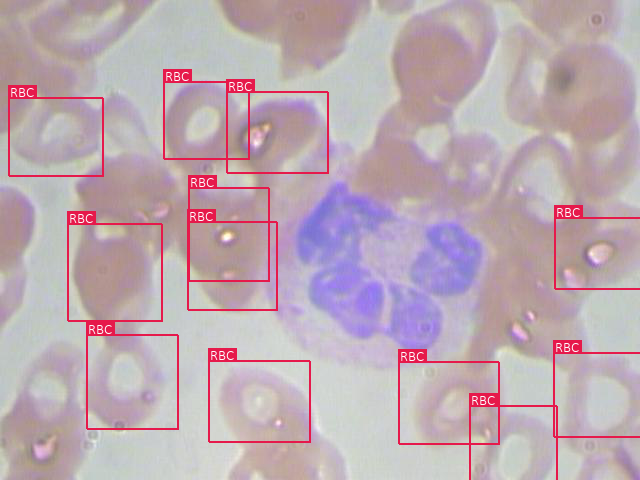

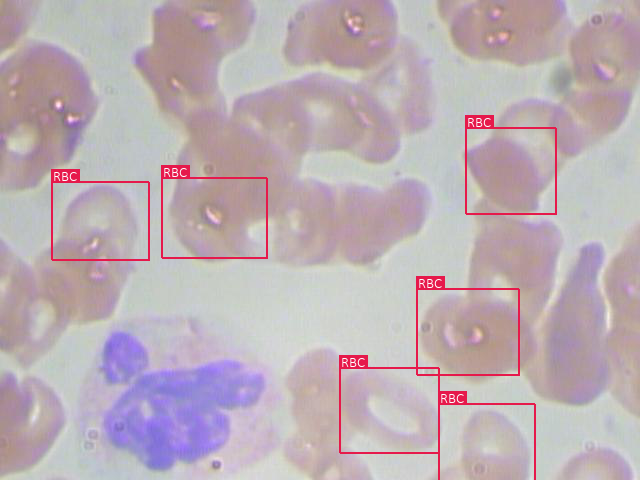

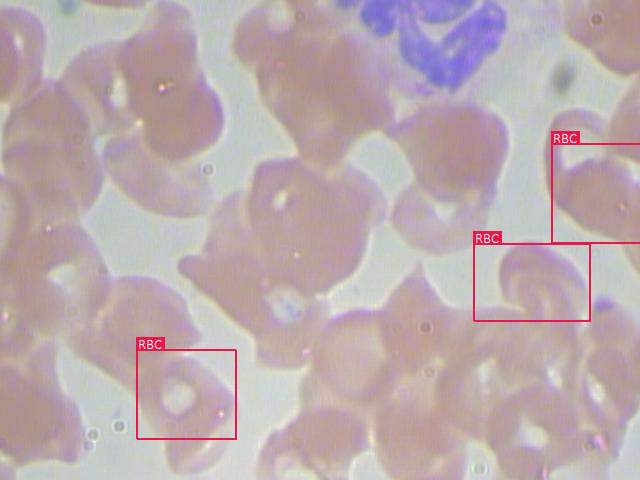

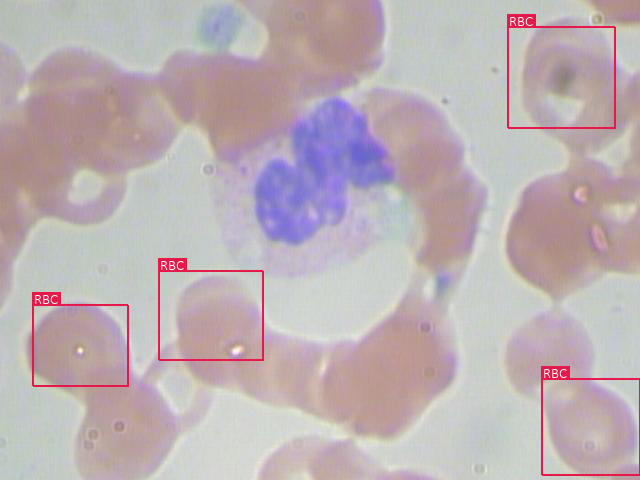

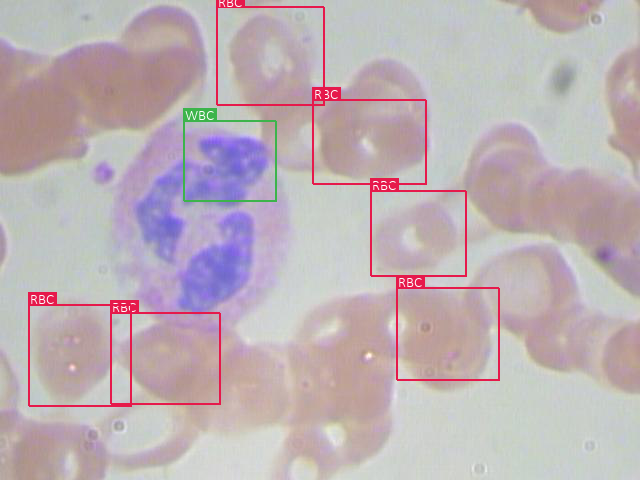

In [28]:
from detect import detect
from IPython.display import display
from PIL import Image

images = [
  '/content/BCCD_Dataset-1.0/BCCD/JPEGImages/BloodImage_00000.jpg',
  '/content/BCCD_Dataset-1.0/BCCD/JPEGImages/BloodImage_00001.jpg',
  '/content/BCCD_Dataset-1.0/BCCD/JPEGImages/BloodImage_00002.jpg',
  '/content/BCCD_Dataset-1.0/BCCD/JPEGImages/BloodImage_00007.jpg',
  '/content/BCCD_Dataset-1.0/BCCD/JPEGImages/BloodImage_00011.jpg',
]
for img_path in images:
  original_image = Image.open(img_path, mode='r')
  original_image = original_image.convert('RGB')
  image = detect(rev_label_map, label_color_map, original_image, min_score=0.4, max_overlap=0.5, top_k=20)
  display(image)